In [1]:
!pip install tensorflow keras tensorflow-model-optimization keras-tuner

In [2]:
!pip install --upgrade tensorflow keras keras-tuner

In [3]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [4]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full),(X_test,y_test) = cifar10.load_data()

In [5]:
X_train_full.shape

(50000, 32, 32, 3)

In [6]:
X_test.shape

(10000, 32, 32, 3)

In [7]:
X_train_full[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

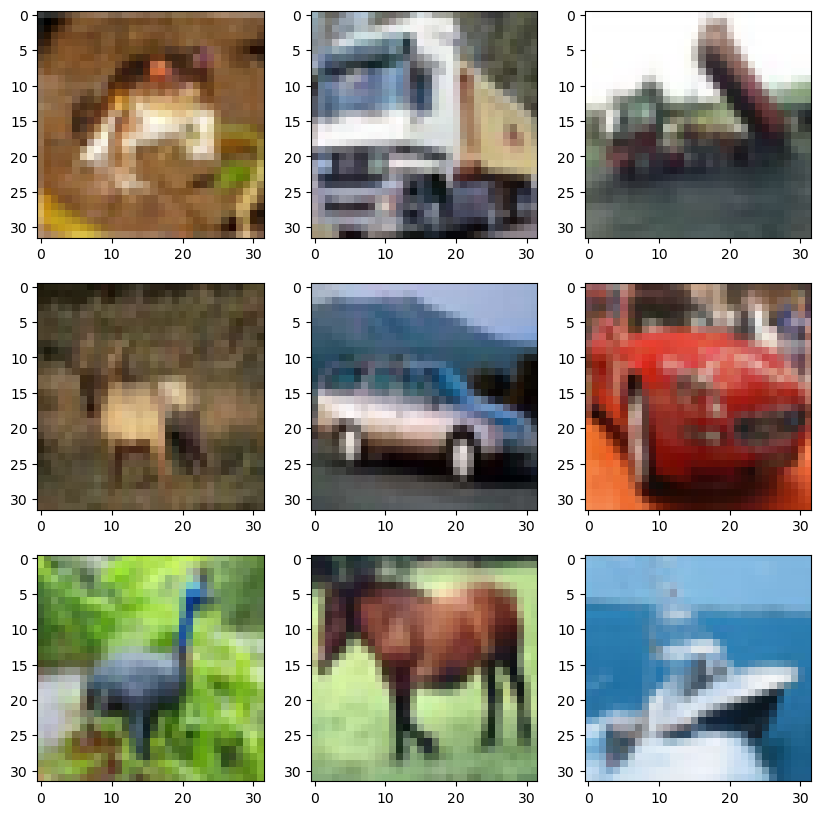

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
a = 0

for i in range(3):
    for j in range(3):        
        axes[i, j].imshow(X_train_full[a], cmap=plt.get_cmap('gray'))
        a = a + 1

plt.show()

In [9]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [10]:
class_names[y_train_full[8][0]]

'ship'

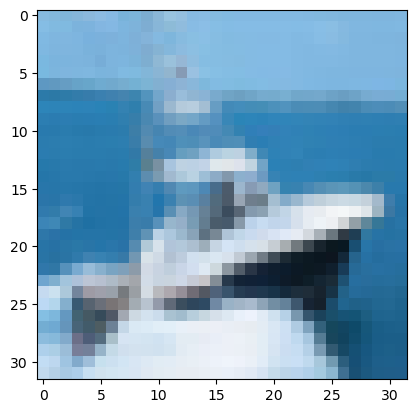

In [11]:
plt.imshow(X_train_full[8], cmap=plt.get_cmap('gray'))

In [12]:
X_valid, X_train = X_train_full[:5000] / 255, X_train_full[5000:]/255
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255

In [13]:
X_train[0]

array([[[0.23529412, 0.32156863, 0.21176471],
        [0.15686275, 0.26666667, 0.14117647],
        [0.20392157, 0.31764706, 0.20392157],
        ...,
        [0.20784314, 0.16862745, 0.19607843],
        [0.25882353, 0.21568627, 0.23921569],
        [0.28627451, 0.24313725, 0.26666667]],

       [[0.43921569, 0.44705882, 0.44705882],
        [0.22745098, 0.27843137, 0.21960784],
        [0.22745098, 0.31764706, 0.20784314],
        ...,
        [0.21176471, 0.18431373, 0.20784314],
        [0.2627451 , 0.22745098, 0.25490196],
        [0.28235294, 0.24313725, 0.27058824]],

       [[0.66666667, 0.63137255, 0.69803922],
        [0.46666667, 0.4627451 , 0.47058824],
        [0.31372549, 0.34901961, 0.29019608],
        ...,
        [0.21960784, 0.19607843, 0.21960784],
        [0.2745098 , 0.24705882, 0.2745098 ],
        [0.28235294, 0.25098039, 0.27843137]],

       ...,

       [[0.35686275, 0.44313725, 0.36862745],
        [0.23137255, 0.3254902 , 0.24313725],
        [0.17647059, 0

In [14]:
# def exponential_decay(epoch):
#         return 0.01*0.1**(epoch/10)
    
# exponential_decay_fn = exponential_decay
# lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [15]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

def create_model(neurons1, neurons2, lr):
    model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[32,32,3]),
        # keras.layers.AlphaDropout(rate=0.1),
        keras.layers.Dense(neurons1, kernel_initializer='lecun_normal', activation='selu'),
        # keras.layers.AlphaDropout(rate=0.1),
        keras.layers.Dense(neurons2, kernel_initializer='lecun_normal', activation='selu'),
        # keras.layers.AlphaDropout(rate=0.1),
        keras.layers.Dense(300, kernel_initializer='lecun_normal', activation='selu'),
        # keras.layers.AlphaDropout(rate=0.1),
        keras.layers.Dense(300, kernel_initializer='lecun_normal', activation='selu'),
        # keras.layers.AlphaDropout(rate=0.1),
        keras.layers.Dense(300, kernel_initializer='lecun_normal', activation='selu'),
        # keras.layers.AlphaDropout(rate=0.1),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr), 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    return model

def build_model(hp):
    neurons1 = hp.Int("units1", min_value=32, max_value=512, step=32)
    neurons2 = hp.Int("units2", min_value=32, max_value=512, step=32)
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    model = create_model(neurons1=neurons1, neurons2=neurons2, lr=lr)
    return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    overwrite=True
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)

Trial 10 Complete [00h 00m 53s]
val_loss: 1.5310126543045044

Best val_loss So Far: 1.4856656789779663
Total elapsed time: 00h 09m 38s


In [16]:
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(best_hps.get('units1'))
print(best_hps.get('units2'))
print(best_hps.get('learning_rate'))

best_model.summary()

416
256
0.004213437762323442


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 416)            │     1,278,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       106,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 300)            │        77,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 300)            │        90,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         3,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,830 (6.28 MB)

 Trainable params: 1,645,830 (6.28 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = best_model.fit(X_train, y_train, epochs=60, validation_data = (X_valid, y_valid), batch_size=32)

Epoch 1/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5106 - loss: 1.3731 - val_accuracy: 0.4938 - val_loss: 1.4642
Epoch 2/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5210 - loss: 1.3438 - val_accuracy: 0.4780 - val_loss: 1.4610
Epoch 3/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5335 - loss: 1.3188 - val_accuracy: 0.4674 - val_loss: 1.4796
Epoch 4/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5406 - loss: 1.2942 - val_accuracy: 0.4700 - val_loss: 1.4915
Epoch 5/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5505 - loss: 1.2754 - val_accuracy: 0.3866 - val_loss: 1.7884
Epoch 6/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5571 - loss: 1.2504 - val_accuracy: 0.4486 - val_loss: 1.5626
Epoch 7/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5711 - loss: 1.2185 - val_accuracy: 0.4402 - val_loss: 1.6157
Epoch 8/60
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5660 - loss: 1.2117 - 

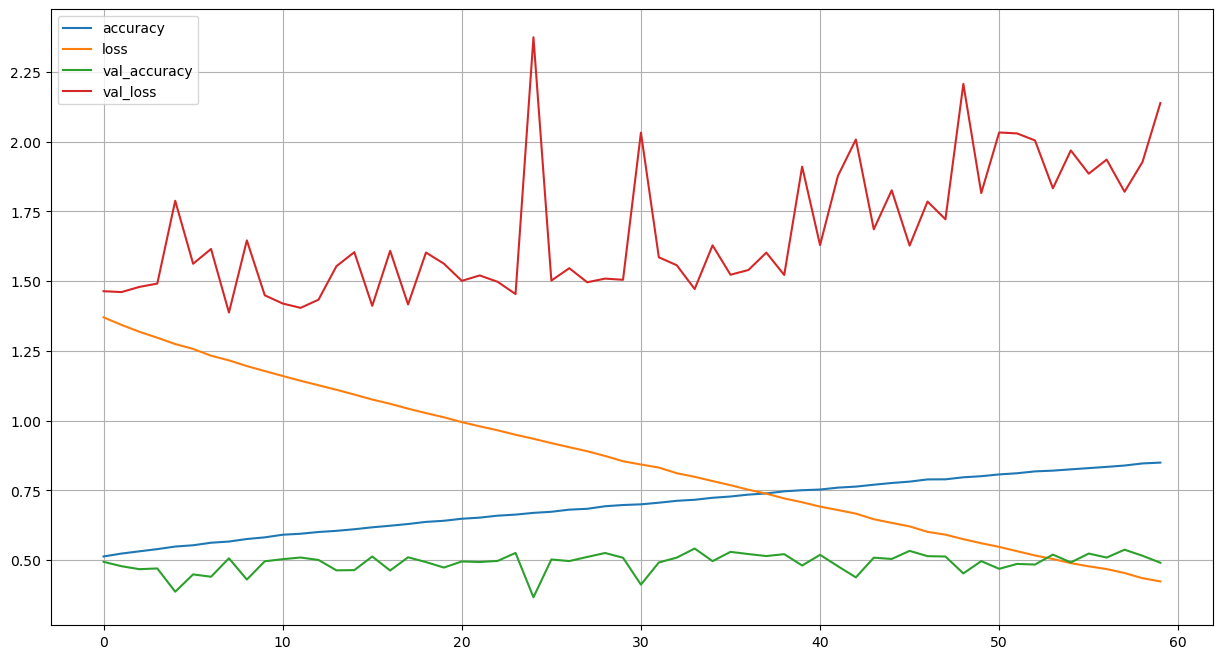

In [20]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca()
plt.show()

In [21]:
best_model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4926 - loss: 2.1262


[2.0911166667938232, 0.49619999527931213]

In [22]:
y_prob = best_model.predict(X_test)
y_classes = y_prob.argmax(axis=-1)
y_classes

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [23]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_classes)

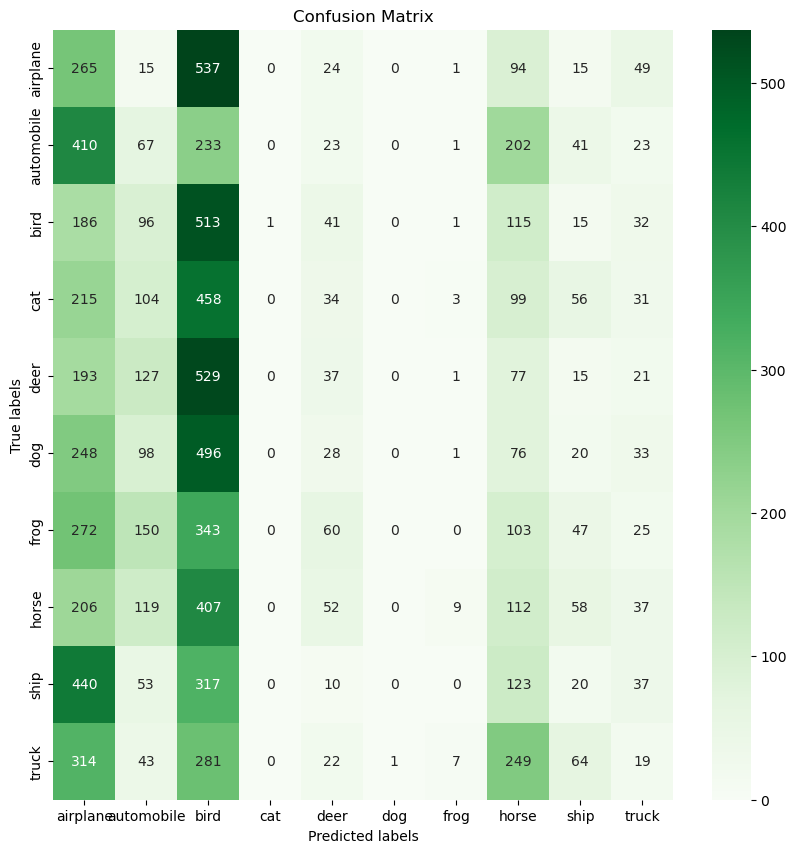

In [24]:
import seaborn as sb    

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Greens')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.xaxis.set_ticklabels(class_names) 
fig.yaxis.set_ticklabels(class_names)
fig.figure.set_size_inches(10, 10)


plt.show()